In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
D_train = 100
D_test = 100

N_train = 25
N_test = 1000

#############Training Set#############
x_train = np.sort(np.random.uniform(0,1,(D_train,N_train,1)),axis=1)

e_train = np.random.normal(0,0.3,(D_train,N_train,1))

t_train = np.sin(2*np.pi*x_train) + e_train

#############Test Set#############
x_test = np.sort(np.random.uniform(0,1,(D_test,N_test,1)),axis=1)

e_test = np.random.normal(0,0.3,(D_test,N_test,1))

t_test = np.sin(2*np.pi*x_test) + e_test

In [14]:
#############Regularization Parameters#############

ln_lambdas = np.linspace(-2.2,2.5,50)

lambdas = np.exp(ln_lambdas)

M = 25

In [15]:
def designMatrix(x,M,s):    ##Non Linear Mapping to RBFs
    
    s = s**2
    N = len(x)
    
    X = np.zeros((N,M))
    poi = np.linspace(0,1,M)
    
    for i in range(N):
        X[i,:] = np.exp(-1*np.power(x[i] - poi.T,2)/(2*s)) 
    
    phi = np.hstack((np.ones((N,1)),X))
    
    return phi

In [16]:
def cost(f,t):
    return np.sum(np.power(f - t,2))

In [17]:
def closedForm(x,t,M,lamb):
    return np.linalg.inv(x.T@x+lamb*np.eye(M+1)) @ x.T @ t

In [18]:
def gaussianFit(x_train,t,N,M,D,lambdas,plot=True):
    x_mesh = np.linspace(0,1,N).reshape(N,1)
    phi_mesh = designMatrix(x_mesh,M,0.1)
    f_x = []
    y_mesh = np.zeros((len(lambdas), D, N,1))
    w = np.zeros((len(lambdas), D,M+1,1))
    h_x = np.sin(2*np.pi*x_mesh)

    for j in range(len(lambdas)):
        for i in range(D):
            phi_train = designMatrix(x_train[i],M,0.1)
            w[j,i,:] = closedForm(phi_train,t[i],M,lambdas[j])
            
            if plot:
                y_mesh[j,i,:] = phi_mesh@w[j,i]
                plt.plot(x_mesh,y_mesh[j,i,:],'r')
                plt.ylim([-2,2])
                plt.title('ln(lambda): ' + str(np.log(lambdas[j])))
        if plot:
            plt.figure()
        f_x.append(np.mean(y_mesh[j],axis=0))

    if plot:
        for j in range(len(lambdas)):
            plt.figure()
            plt.plot(x_mesh, h_x,'g')
            plt.plot(x_mesh,f_x[j],'r')
            plt.ylim([-1.5,1.5])
            plt.title('Average ln(lambda): ' + str(np.log(lambdas[j])))
    return w

In [19]:
def prediction(x, lambdas, D, N, w):
    y_estimates_test = np.zeros((len(lambdas), D, N,1))
    phi = []
    
    for i in range(D):
        phi = designMatrix(x[i],M,0.1)
        for j in range(len(lambdas)):
            y_estimates_test[j,i,:] = phi@w[j,i]

    return y_estimates_test

In [20]:
def biasVariance(w, lambdas, y_hat, D):
    N = 25
    x_mesh = np.linspace(0,1,N).reshape(N,1)
    phi_mesh = designMatrix(x_mesh,M,0.1)
    h_x = np.sin(2*np.pi*x_mesh)
    f_x = []
    y = np.zeros((len(lambdas), D, N,1))
    ln_lambdas = np.log(lambdas)
    E = np.zeros((len(lambdas),1))
    
    for j in range(len(lambdas)):
        for i in range(D):
            y[j,i,:] = phi_mesh@w[j,i]
        f_x.append(np.mean(y[j],axis=0))
        
    bias_sq = np.zeros((len(lambdas),1))
    for i in range(len(lambdas)):
        bias_sq[i] = np.mean(np.power(f_x[i]-h_x,2))

    variance = np.zeros((len(lambdas),1))
    for i in range(len(lambdas)):
        variance[i] = np.mean(np.mean(np.power(y[i]-f_x[i],2),axis=0))
              
    N = 1000
    x_mesh = np.linspace(0,1,N).reshape(N,1)
    true_avg = np.mean(t_test,0)
    for i in range(len(lambdas)):
        E[i] = np.sqrt(cost(true_avg,np.mean(y_hat[i],0))/N)

    plt.plot(ln_lambdas,bias_sq,'blue')
    plt.plot(ln_lambdas,variance,'r')
    plt.plot(ln_lambdas,bias_sq+variance,'m')
    plt.plot(ln_lambdas,(E), 'k')

    plt.legend(['(bias)^2','variance','bias^2 + variance','test error'])
    plt.xlabel('ln λ')
    plt.ylim([0, 0.15])

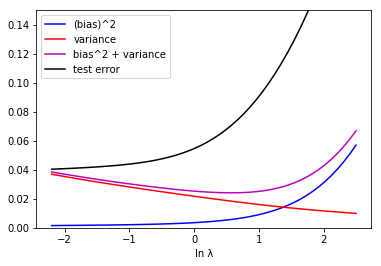

In [22]:
w = gaussianFit(x_train,t_train,N_train,M,D_train,lambdas,False)

y_hat = prediction(x_test, lambdas, D_train, N_test, w)

biasVariance(w, lambdas,y_hat, D_train)
plt.show()